#### **Python env**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

from pathlib import Path
from warnings import simplefilter

from sklearn.metrics import mean_squared_error
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

In [4]:
plt.style.use("seaborn-whitegrid")

plt.rc(
    "figure",
    autolayout = True,
    figsize = (11, 4),
    titlesize = 18,
    titleweight = "bold"
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)


#### **Linear regression**

The interesting features that could be used to solve this problem are time and lags. In order to solce the problem, maybe a combination of the two could be used.

In [ ]:
df = pd.read_csv("store-sales-time-series-forecasting/book_sales.csv", parse_dates = ["Date"])
df = df.drop(["Paperback"], axis = 1)
df.head()

In [ ]:
df["Time"] = range(0, df.shape[0])

In [ ]:
fig, ax = plt.subplots()
ax.plot("Time", "Hardcover", data = df, color = '0.7')
ax = sns.regplot(x = "Time", y = "Hardcover", data = df, ci = 95, scatter_kws = dict(color = "0.25"))
ax.set_title('Time Plot of Hardcover Sales')
ax.grid(False);

In [ ]:
lr = LinearRegression()

lr.fit(X = df["Time"].values.reshape(-1, 1), y = df["Hardcover"].values)

lr.coef_[0], lr.intercept_

In [ ]:
df["Hardcover"].values

In [ ]:
df["Lag_1"] = df.Hardcover.shift(1)
df.head()

In [ ]:
# dato che si osserva una correlazione tra la variabile e il suo lag, 
# tale lag dovrebbe essere tenuto in considerazione per le analisi.
# Stiamo tenendo in considerazione una dipendenza seriale: il sales di un
# giorno sarà minore di quello successivo.  

fig, ax = plt.subplots()
ax = sns.regplot(x = "Lag_1", y = "Hardcover", data = df[["Lag_1", "Hardcover"]], ci = 95, scatter_kws = dict(color = "0.25"))
ax.set_title('Lag Plot of Hardcover Sales')
ax.grid(False);

In [ ]:
lr = LinearRegression()

lr.fit(X = df["Lag_1"].values[1:].reshape(-1, 1), y = df["Hardcover"].values[1:])

lr.coef_[0], lr.intercept_

In [ ]:
lr = LinearRegression()

lr.fit(X = df[["Time", "Lag_1"]].values[1:,:], y = df["Hardcover"].values[1:])

lr.coef_[0], lr.intercept_

#### **Trend**

A _trend_ represents the change in the mean of a time series and it is the slowest-moving part of a series.

Generally speaking, a trend is a slow-moving and persistent change which could involve the mean but also other measures, like the median. Moreover, 
it could be linear or also a persistent and slow-moving seasonal. 

So, in order to highlight the type of trend, a rolling mean could be performed so that any short-term trend should be deleted. Therefore, the width of
the rolling mean should be larger than the seasonal period.   

In [ ]:
df = pd.read_csv("archive/tunnel.csv")
df["Day"] = pd.to_datetime(df["Day"])
df["Time"] = range(0, df.shape[0])
df.head()

In [ ]:
fig, ax = plt.subplots()
ax.plot("Time", "NumVehicles", data = df, color = '0.7', zorder = 0)
ax = sns.regplot(x = "Time", y = "NumVehicles", data = df, ci = 95, scatter_kws = dict(color = "0.25"))
ax.set_title('Time Plot of Hardcover Sales')
ax.grid(False);

In [ ]:
moving_average = df.rolling(
    window = 365,
    center = True,
    min_periods = 183
).mean()

ax = df["NumVehicles"].plot()
moving_average["NumVehicles"].plot(ax = ax, linewidth = 3)
ax.grid(False);

# possiamo vedere che il trend è lineare.

In [ ]:
# una volta che il trend è stato identificato, possiamo modellarlo: in questo caso, possiamo ottenere le features
# da un processo deterministico.

from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index = df.Time,    # regressor
    constant = False,    # bias
    order = 1,          # order of the regression
    drop = True         # avoid collinearity
)

# feature estratte per i dati di training. 

X = dp.in_sample()
X.head(5)

In [ ]:
from sklearn.linear_model import LinearRegression

y = df["NumVehicles"]

model = LinearRegression(fit_intercept = True)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)

X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(y, color = "red", alpha = .7, label = "Data")
plt.plot(y_pred, color = "black", alpha = .7, label = "In-sample predictions")
plt.plot(y_fore, color = "black", ls = "--", alpha = .7, label = "Out-sample predictions")
plt.legend()
plt.grid(False)

#### **Seasonality**

Oscillazioni attorno alla media in modo regolari e periodiche danno vita alla _stagionalità_. Tendenzialmente, sono legate al calendario naturale.

In base alla frequenze, possiamo definire due modi per definire la stagionalità: se è settimanale o giornaliera, si possono usare le variabili dummy. altrimenti la trasformata i Fourier. Questo perché l'approccio con le dummy si basa sul fatto di considerare tanti regressori quanto il periodo e se quest'ultimo dovesse essere grande, allora i regressori in gioco potrebbero essere eccessivi.

##### **Seasonal plot**

Vengono utilizzati per plottare i dati nello stesso intervallo di tempo.

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [ ]:
tunnel = pd.read_csv("archive/tunnel.csv", parse_dates=["Day"])
tunnel.set_index(["Day"], inplace = True)
tunnel.head()

In [ ]:
# un grafico per analizzare la stagionalità è il seasonal plot.

X = tunnel.copy()

# day in a week.
X["day"] = X.index.day_of_week
X["week"] = X.index.week
# day in a year.
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

##### **Dummy**

Per tenere in considerazione le stagionalità corte nella regressione, è possibile tenere 
in considerazione il fatto che per alcuni momenti della stagionalità, come le ore o il giorno,
il valore medio della serie puù aumentare o diminuire. Per tenere in considerazione questo aspetto,
è possiile sfruttare le dummy. Si ricordi però che nel one-hot-encoding una variabile dummy deve essere
eliminata se si considera l'intercetta. 

##### **Periodigramma**

Se il periodo è piuttosto lungo, dovrei considerare  molti regressori. Di conseguenza, si utilizza la trasformata di Fourier in modo da considerare la overall shape della stagionalità. 

Per capire quante coppie sin/cos considerare, si utilizza il periodigramma il quale mostra $(a**2+b**2) / 2$ dove $a$ e $b$ rappresentano i coeff di Fourier per una frequenza fissata. Ovviamente questo è un risultato globale, poi è l'utente a dire in che modo dovranno essere modellate tali frequenze. 

In [ ]:

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(tunnel.NumVehicles);

# si osserva che vi è una forte stagionalità settimanale ma non annuale.

In [ ]:
tunnel.index.to_period("D")

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


fourier = CalendarFourier(freq = "A", order = 10)

dp = DeterministicProcess(
    index=tunnel.index.to_period("D"),
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

In [ ]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)

y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

In [ ]:
ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

#### **Time series as features**

Fino ad adesso abbiamo analizzato solo le dipendenze temporali, ovvero quelle che dipendono dal timestamp. SI vuole ora considerare un'altra features per la previsione delle serie storiche, ovvero la dipendenza seriale che riguarda la correlazione che interecorre tra i valori del segnale e dei precedenti. 

Tale dipendenza può essere evidenziata a partire dai grafici dei lag.Per capire quali possano essere i lag più importanti da introdurre nel modello è possibile sfruttare l'informazione contenuta nel **correlogramma**.

Un componente che può essere predetta opportunamente è proprio il ciclo, ovvero una sorta di stagionalità "lunga" che non ha un periodo fisso. 

Per aumentare il potere predittivo del modello è possibile utilizzare anche i _leading indicators_, ovvero delle features che anticipano l'avvenimento di un fenomeno.

In [13]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

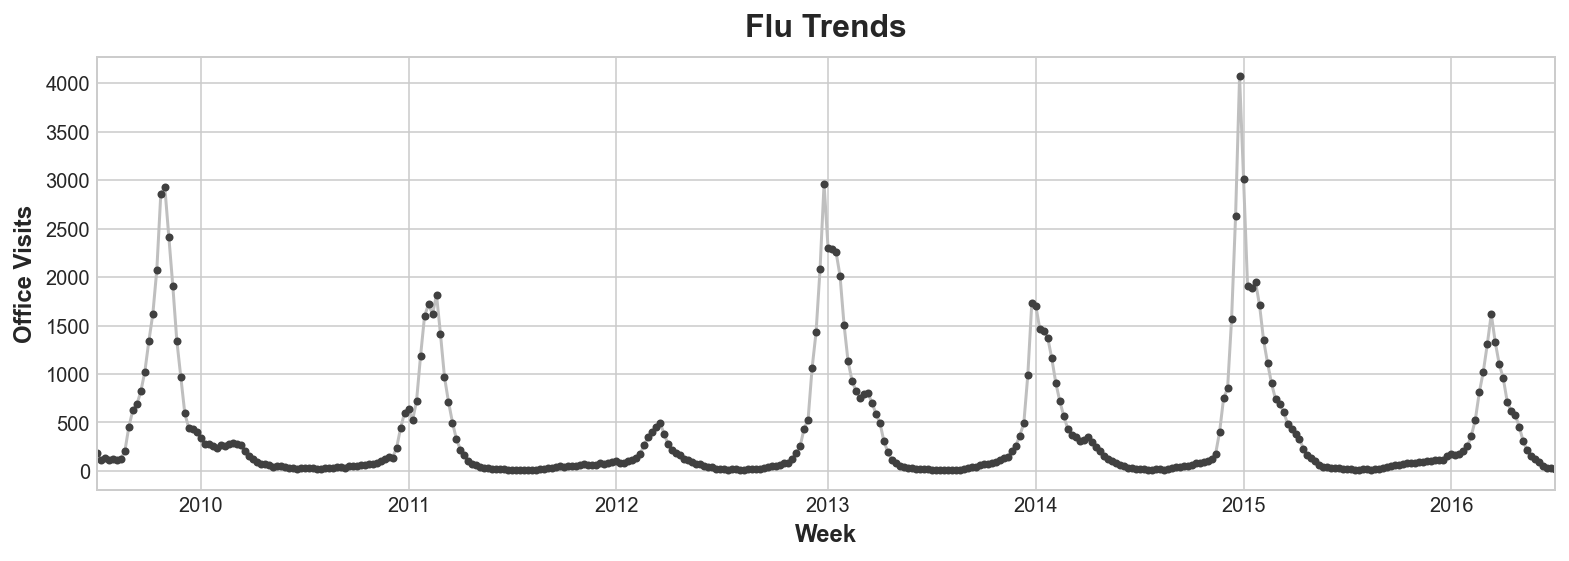

In [10]:
data_dir = Path("ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

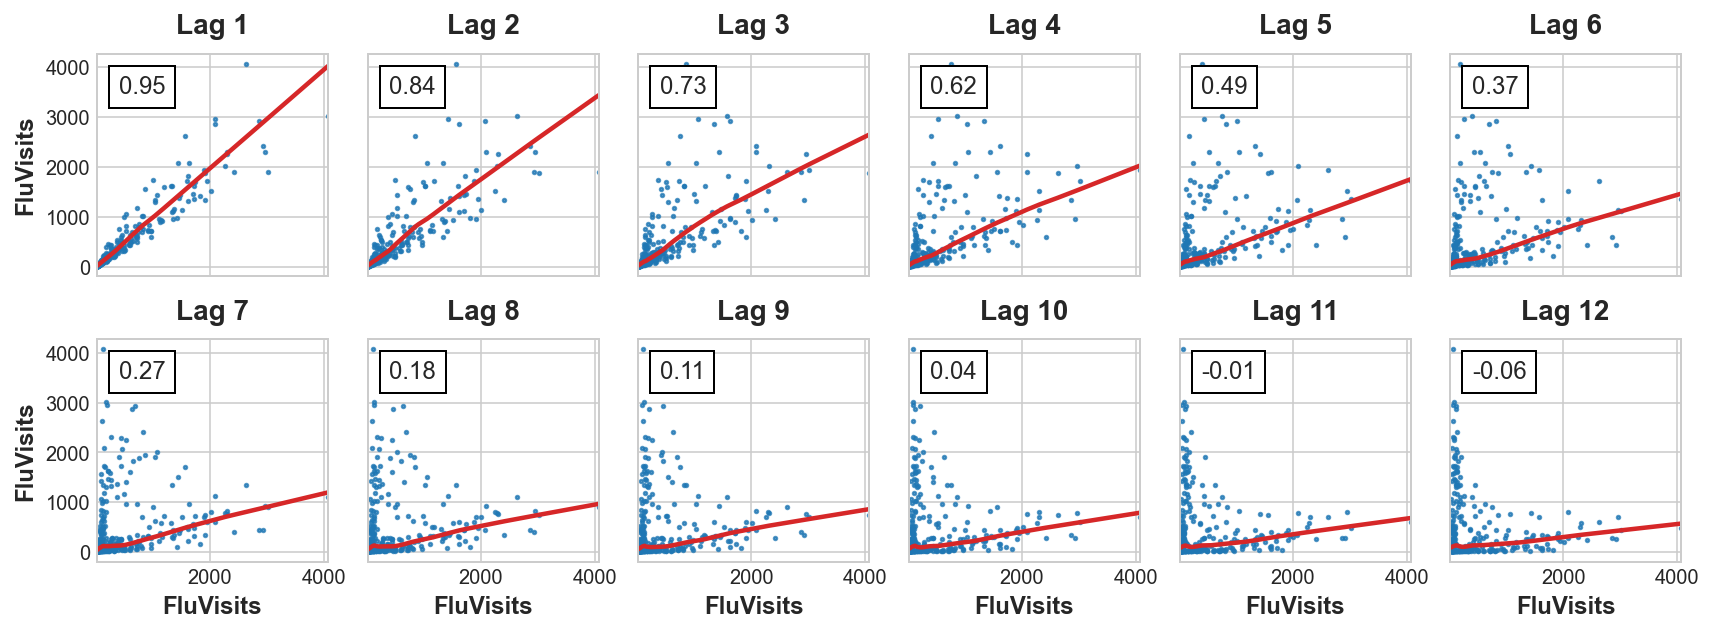

In [14]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)

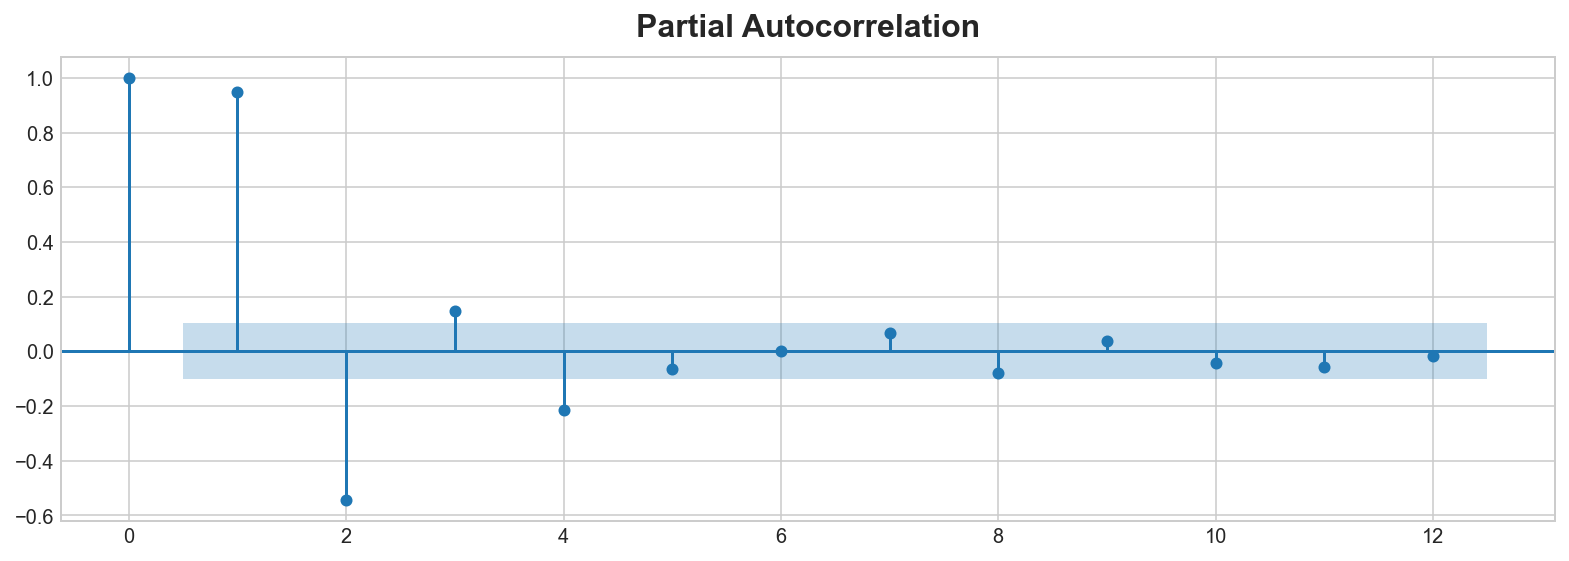

In [15]:
_ = plot_pacf(flu_trends.FluVisits, lags=12)

In [17]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)
X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0


In [18]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

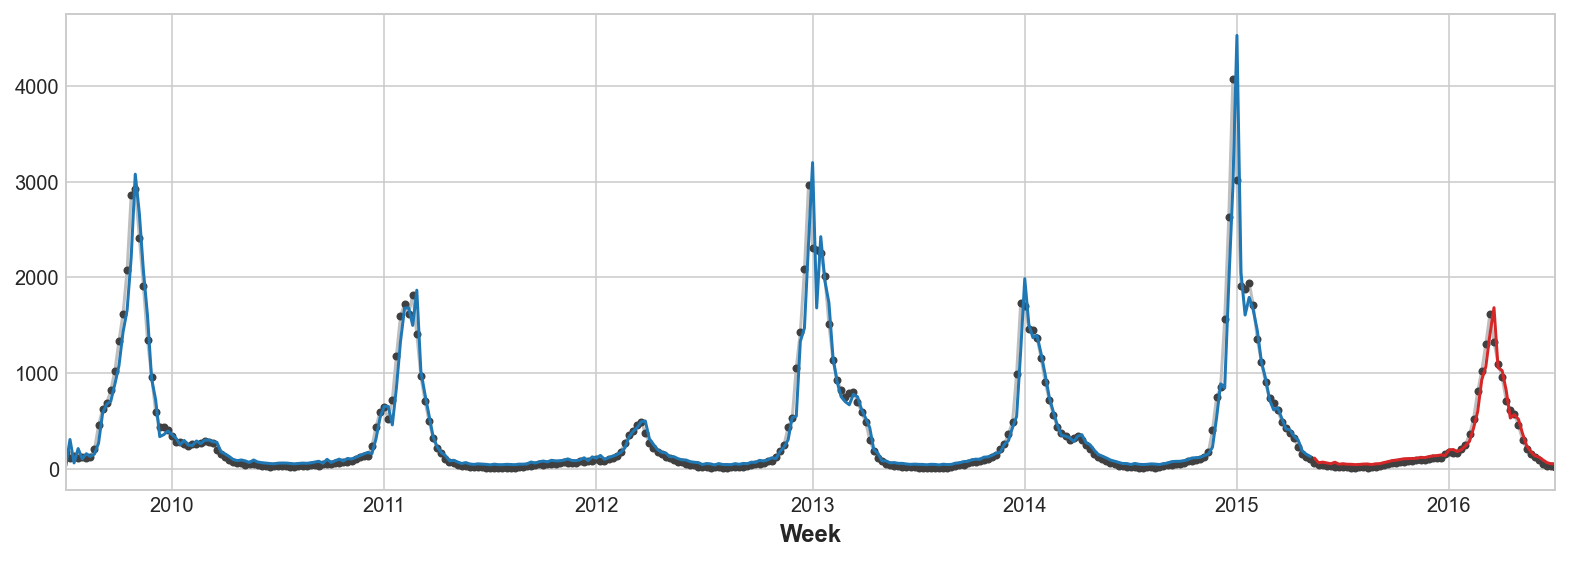

In [19]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

#### **Hybrid models**

Fino ad ora abbiamo analizzato diverse componenti delle serie storiche, i.e. trend, stagionalità e ciclo, le quali sono state modellate attraverso la regressione lineare.

Tuttavia, poiché tali componenti sono additive, è possibile creare un solo modello con tutte le componenti oppure usare un modello per ogni componente/residuo per scegliere ogni volta il migliore.

Gli algoritmi di regressione possono operare in due modi diversi:
- A partire dalle features, si apprende una funzione per ottenere il valore target, come la regressione lineare o le reti. Di conseguenza, questi algoritmi sono in grado di fornire una previsione al di fuori dei valori del training set. 
- Le features definiscono dei gruppi dal quale si ottiene il valore del target a partire dai valori "vicini" sempre della variabile target, come gli alberi o KNN. Di conseguenza, questi algoritmi non sono in grado di fornire una previsione al di fuori dei valori del training set perché l'approccio che utilizzano è intrinsicamente legato allo spazio delle features iniziale. Infatti, tutti gli algoritmi di previsione che si basano sugli alberi, e.g. decision trees o random forest, non possono prevedere i trend. 

Quindi nel primo caso il valore del target non dipende dai valori di altri target, nel secondo caso questo accade. 

Inoltre, la regressione lineare non è in grado di apprendere l'interazione tra segnali diversi, poiché l'ottimizzazione è univariata, che andranno introdotte utilizzando altri algoritmi. 

In [22]:
data_dir = Path("ts-course-data/")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

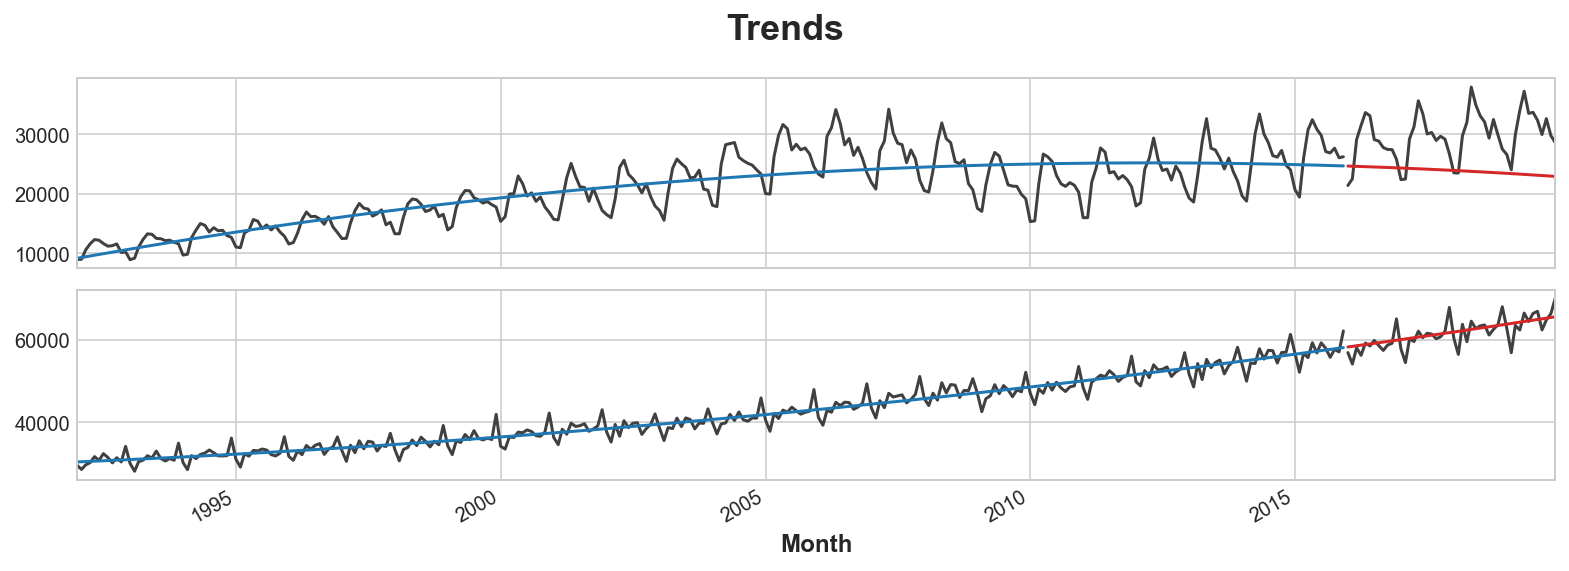

In [23]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

La regressione lineare è in grado di gestire i casi multivariati ma XGboost no. 

In [24]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [26]:
# Now we'll convert the trend predictions made earlier to long format and then 
# subtract them from the original series. That will give us detrended 
# (residual) series that XGBoost can learn.

# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [27]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

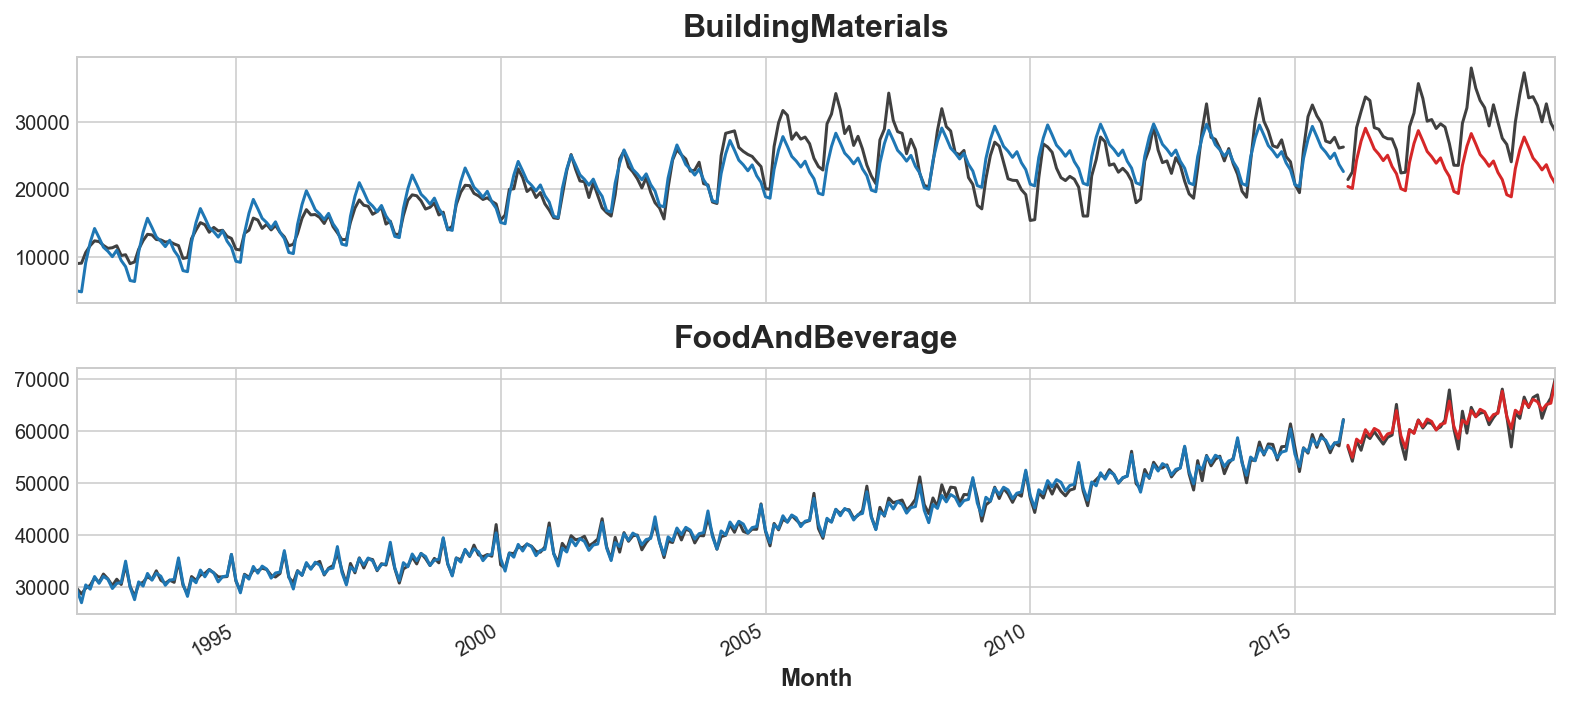

In [28]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

#### **Forecasting with machine learning**

Per calcolare delle previsioni è necessario definire le seguenti: 
- il segnale di input (features)
- l'orizzonte di previsione

per poi applicare una di queste quattro strategie:

- Multioutput model: usare dei modelli che sono in grado di prevedere più steps in una sola volta, come la regressione lineare o le reti neurali. XGboost non è in grado.
- Direct strategy: trainare un modello per ogni step nella finestra di previsione.
- Recursive strategy: le previsioni vengono utilizzate come lag per calcolare le previsioni successive. Poiché gli errori si propagano, per finestre di previsione particolarmente grandi potrebbe risultare non accurata. 
- DirRec strategy: mix between the 2 and 3 strategy.

In [2]:

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

In [16]:

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

In [17]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [11]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 389.12
Test RMSE: 582.33


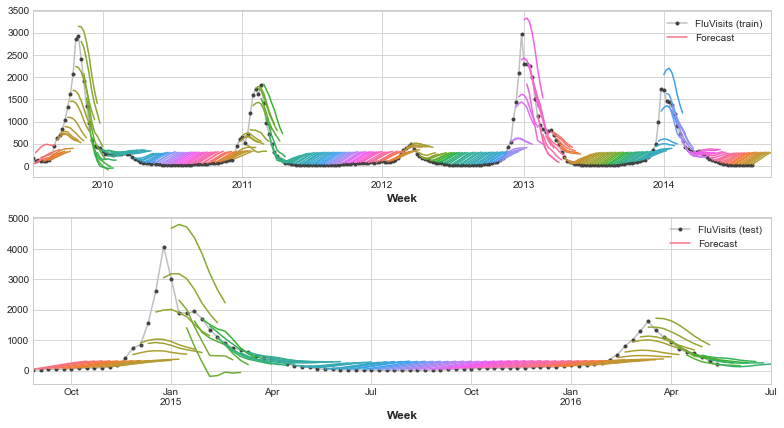

In [15]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

In [20]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 1.22
Test RMSE: 526.45


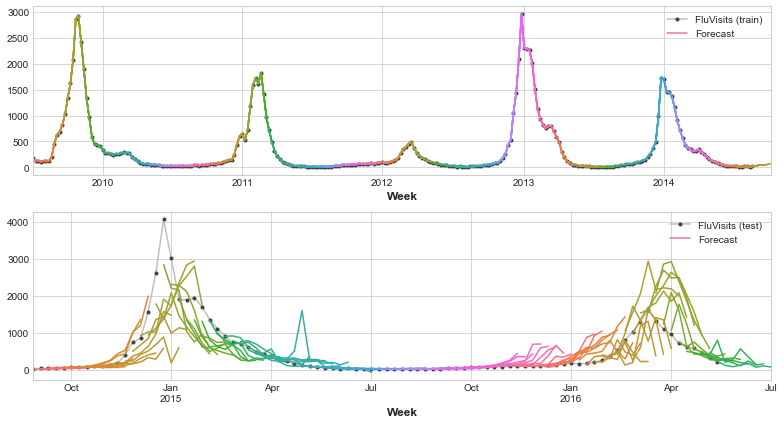

In [21]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])